In [1]:
!pip install remotezip tqdm opencv-python einops
!pip install -U tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolve

In [2]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

2025-05-06 05:50:00.006538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746510600.041953      19 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746510600.049287      19 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746510600.070174      19 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746510600.070199      19 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746510600.070202      19 computation_placer.cc:177] computation placer alr

In [3]:
# install gdown if needed
!pip install --quiet gdown


file_id = "13jYtL2Yfgwr8prJQ6kOVQA0b1AmvX8l3"
zip_path = "/kaggle/working/dataset.zip"

# download
!gdown {file_id} --output {zip_path}

# unzip
import zipfile, pathlib
extract_dir = pathlib.Path("/kaggle/working/data")
extract_dir.mkdir(exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

train_dir = extract_dir / "dataset" / "train"
test_dir  = extract_dir / "dataset" / "test"
print("Train/Test folders:", train_dir.exists(), test_dir.exists())


Downloading...
From (original): https://drive.google.com/uc?id=13jYtL2Yfgwr8prJQ6kOVQA0b1AmvX8l3
From (redirected): https://drive.google.com/uc?id=13jYtL2Yfgwr8prJQ6kOVQA0b1AmvX8l3&confirm=t&uuid=06b8cec3-0c20-4fcf-96f9-26fbdfec0d2d
To: /kaggle/working/dataset.zip
100%|██████████████████████████████████████| 4.13G/4.13G [00:54<00:00, 76.1MB/s]
Train/Test folders: True True


In [4]:
import os, shutil
val_dir = extract_dir / 'dataset/val'
val_dir.mkdir(exist_ok=True)

# Split each class folder in train into train/ and val/
for class_dir in train_dir.iterdir():
    if class_dir.is_dir():
        videos = list(class_dir.glob('*.mp4'))
        n_val = int(len(videos) * 0.2)  # use 20% for validation
        # Create corresponding class folder in val_dir
        target_class_dir = val_dir / class_dir.name
        target_class_dir.mkdir(exist_ok=True)
        # Move videos to val folder
        for vid in videos[:n_val]:
            shutil.move(str(vid), str(target_class_dir / vid.name))


In [5]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
    def __init__(self, path, n_frames, training=False):
        """
        Args:
          path: pathlib.Path to the dataset split (train/val/test).
          n_frames: Number of frames to sample per video.
          training: If True, shuffle videos each epoch.
        """
        self.path = pathlib.Path(path)
        self.n_frames = n_frames
        self.training = training
        # Each subdirectory name is a shot type (class).
        self.class_names = sorted([p.name for p in self.path.iterdir() if p.is_dir()])
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        # Find all .mp4 files under class subfolders.
        video_paths = list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))
        if self.training:
            random.shuffle(pairs)
        for path, class_name in pairs:
            # Extract frames from the video file
            video_frames = frames_from_video_file(path, self.n_frames)
            # Encode shot type label
            shot_label = self.class_ids_for_name[class_name]
            # Parse player number from filename (e.g. "..._player_1_...mp4")
            # Filename stem split: ['<shot>', 'player', '<num>', '<clip>']
            player_num = int(path.stem.split('_')[-2])  # 1 or 2
            player_label = player_num - 1  # convert to 0 or 1
            yield video_frames, (shot_label, player_label)

In [6]:
n_frames = 31
batch_size = 8

# Define output signature: video tensor and a tuple of (shot_label, player_label).
output_signature = (
    tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),  # video frames (num_frames, H, W, 3)
    (tf.TensorSpec(shape=(), dtype=tf.int32),  # shot_label
     tf.TensorSpec(shape=(), dtype=tf.int32))  # player_label
)

# Paths to each split
subset_paths = {
    'train': train_dir,
    'val':   val_dir,
    'test':  test_dir
}

train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['train'], n_frames, training=True),
    output_signature=output_signature
).batch(batch_size)

val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['val'], n_frames, training=False),
    output_signature=output_signature
).batch(batch_size)

test_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['test'], n_frames, training=False),
    output_signature=output_signature
).batch(batch_size)


I0000 00:00:1746510696.217114      19 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746510696.221052      19 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [8]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [9]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [10]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [11]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [12]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [13]:
input_shape = (None, 31, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)

num_shot_classes = len(list(train_dir.iterdir()))  # should be 19
shot_output = layers.Dense(num_shot_classes, activation='softmax', name='shot_output')(x)
player_output = layers.Dense(2, activation='softmax', name='player_output')(x)

model = keras.Model(inputs=input, outputs=[shot_output, player_output])
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss={
      'shot_output':   keras.losses.SparseCategoricalCrossentropy(),
      'player_output': keras.losses.SparseCategoricalCrossentropy()
    },
    metrics={
      'shot_output':   'accuracy',
      'player_output': 'accuracy'
    }
)

In [14]:
frames, label = next(iter(train_ds))
model.build(frames)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define checkpoint callback
checkpoint_cb = ModelCheckpoint(
    filepath='badminton_shot_player_classifier.h5',
    save_best_only=True,                 # only save when val loss improves
    monitor='val_shot_output_loss',      # or 'val_loss' for combined
    mode='min'
)

# Train with callback
history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[checkpoint_cb]
)

Epoch 1/25


I0000 00:00:1746510717.866938      82 service.cc:152] XLA service 0x7c38680023d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746510717.866978      82 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746510717.866984      82 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746510719.906501      82 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-06 05:52:02.447407: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-06 05:52:02.710105: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-06 05:52:04.359560: E external/local_xl

    674/Unknown 1185s 2s/step - loss: 3.3856 - player_output_accuracy: 0.4887 - player_output_loss: 0.7355 - shot_output_accuracy: 0.1548 - shot_output_loss: 2.6500

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-05-06 06:14:36.642816: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-06 06:14:36.915769: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-06 06:14:38.784753: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

674/674 ━━━━━━━━━━━━━━━━━━━━ 1383s 2s/step - loss: 3.3855 - player_output_accuracy: 0.4887 - player_output_loss: 0.7355 - shot_output_accuracy: 0.1548 - shot_output_loss: 2.6500 - val_loss: 3.3019 - val_player_output_accuracy: 0.4944 - val_player_output_loss: 0.7215 - val_shot_output_accuracy: 0.1708 - val_shot_output_loss: 2.5799
Epoch 2/25
674/674 ━━━━━━━━━━━━━━━━━━━━ 1319s 2s/step - loss: 3.3217 - player_output_accuracy: 0.4997 - player_output_loss: 0.7104 - shot_output_accuracy: 0.1554 - shot_output_loss: 2.6112 - val_loss: 3.3350 - val_player_output_accuracy: 0.4944 - val_player_output_loss: 0.7481 - val_shot_output_accuracy: 0.1708 - val_shot_output_loss: 2.5869
Epoch 3/25
674/674 ━━━━━━━━━━━━━━━━━━━━ 1327s 2s/step - loss: 3.3034 - player_output_accuracy: 0.5080 - player_output_loss: 0.7019 - shot_output_accuracy: 0.1449 - shot_output_loss: 2.6016 - val_loss: 3.2726 - val_player_output_accuracy: 0.4944 - val_player_output_loss: 0.6949 - val_shot_output_accuracy: 0.1708 - val_shot

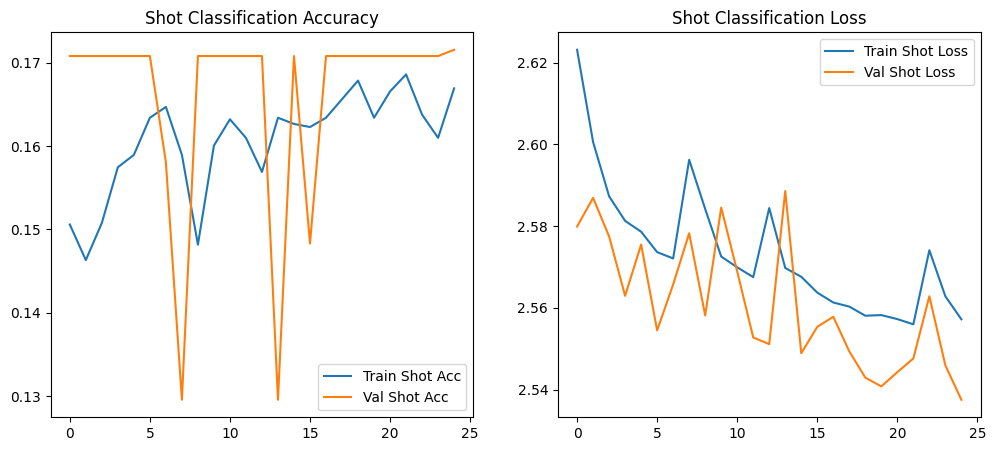

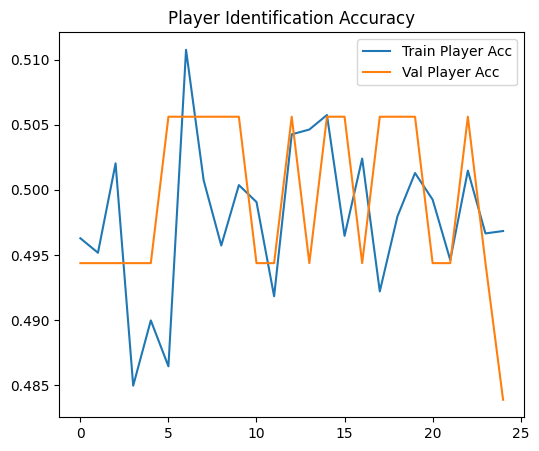

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot shot classification accuracy and loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['shot_output_accuracy'], label='Train Shot Acc')
    plt.plot(history.history['val_shot_output_accuracy'], label='Val Shot Acc')
    plt.title('Shot Classification Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['shot_output_loss'], label='Train Shot Loss')
    plt.plot(history.history['val_shot_output_loss'], label='Val Shot Loss')
    plt.title('Shot Classification Loss')
    plt.legend()
    plt.savefig("Shot_Train_vs_Valid_Acc_and_Loss.png")
    plt.show()

    # Plot player identification accuracy
    plt.figure(figsize=(6,5))
    plt.plot(history.history['player_output_accuracy'], label='Train Player Acc')
    plt.plot(history.history['val_player_output_accuracy'], label='Val Player Acc')
    plt.title('Player Identification Accuracy')
    plt.legend()
    plt.savefig("Player_Train_vs_Valid_Acc_and_Loss.png")
    plt.show()

plot_history(history)

In [17]:
model.evaluate(test_ds, return_dict=True)

    188/Unknown 200s 1s/step - loss: 3.1829 - player_output_accuracy: 0.5056 - player_output_loss: 0.6928 - shot_output_accuracy: 0.2256 - shot_output_loss: 2.4902

2025-05-06 14:57:03.927936: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-06 14:57:04.152583: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-06 14:57:04.998180: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-06 14:57:05.213221: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


189/189 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - loss: 3.1838 - player_output_accuracy: 0.5059 - player_output_loss: 0.6928 - shot_output_accuracy: 0.2251 - shot_output_loss: 2.4910


{'loss': 3.2665250301361084,
 'player_output_accuracy': 0.5348374247550964,
 'player_output_loss': 0.6927439570426941,
 'shot_output_accuracy': 0.18646317720413208,
 'shot_output_loss': 2.573117256164551}

In [18]:
def get_actual_predicted_labels(model, dataset):
    """
    Runs inference over `dataset` and returns two tuples:
      (actual_shots, pred_shots), (actual_players, pred_players)
    where:
      - actual_shots, pred_shots are lists of ints in [0..18]
      - actual_players, pred_players are lists of ints in {0,1}
    """
    actual_shots, actual_players = [], []
    pred_shots, pred_players     = [], []
    
    for batch_videos, (batch_shot_labels, batch_player_labels) in dataset:
        # batch_shot_labels: shape (B,), batch_player_labels: shape (B,)
        # Predict; outputs is a list [shot_logits, player_logits]
        shot_logits, player_logits = model.predict(batch_videos, verbose=0)
        
        # Turn logits → predicted class indexes
        batch_pred_shots   = np.argmax(shot_logits,   axis=1)
        batch_pred_players = np.argmax(player_logits, axis=1)
        
        # Accumulate
        actual_shots .extend(batch_shot_labels.numpy())
        actual_players.extend(batch_player_labels.numpy())
        pred_shots   .extend(batch_pred_shots)
        pred_players .extend(batch_pred_players)
    
    return (actual_shots, pred_shots), (actual_players, pred_players)

In [19]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [20]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

In [21]:
class_names = sorted([p.name for p in train_dir.iterdir() if p.is_dir()])

# Player label names:
player_names = ['player_1', 'player_2']
(acts_shot, preds_shot), (acts_pl, preds_pl) = get_actual_predicted_labels(model, train_ds)

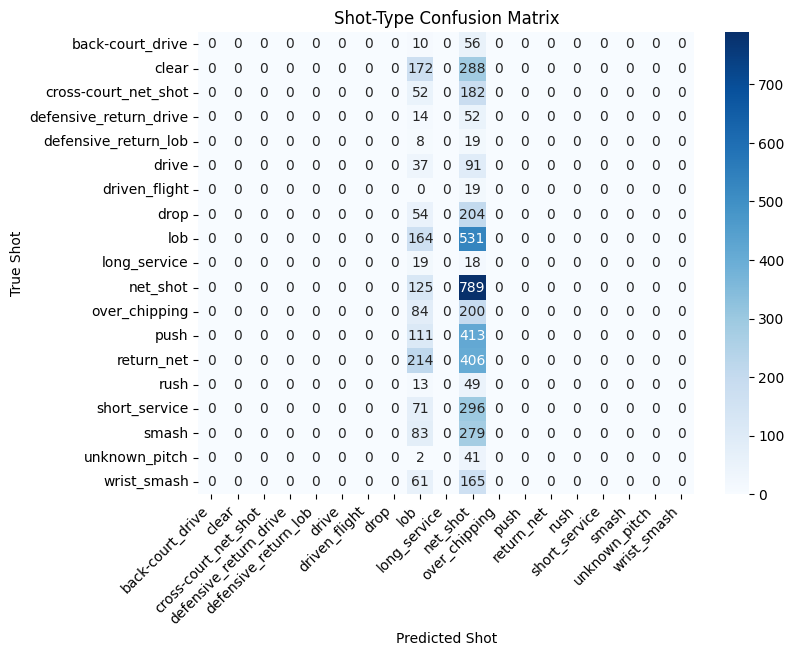

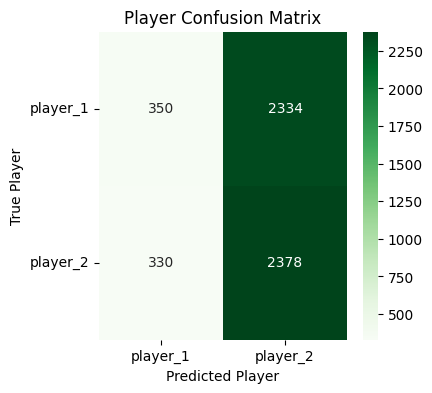

In [22]:
# 2. Shot confusion matrix
cm_shot = tf.math.confusion_matrix(acts_shot, preds_shot)
plt.figure(figsize=(8,6))
sns.heatmap(cm_shot, annot=True, fmt="d", 
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues")

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Shot-Type Confusion Matrix")
plt.xlabel("Predicted Shot"); plt.ylabel("True Shot")
plt.savefig("Shot_Train_Confusion_Matrix.png")
plt.show()

# 3. Player confusion matrix
cm_pl = tf.math.confusion_matrix(acts_pl, preds_pl)
plt.figure(figsize=(4,4))
sns.heatmap(cm_pl, annot=True, fmt="d",
    xticklabels=player_names,
    yticklabels=player_names,
    cmap="Greens")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title("Player Confusion Matrix")
plt.xlabel("Predicted Player"); plt.ylabel("True Player")
plt.savefig("Player_Train_Confusion_Matrix.png")
plt.show()

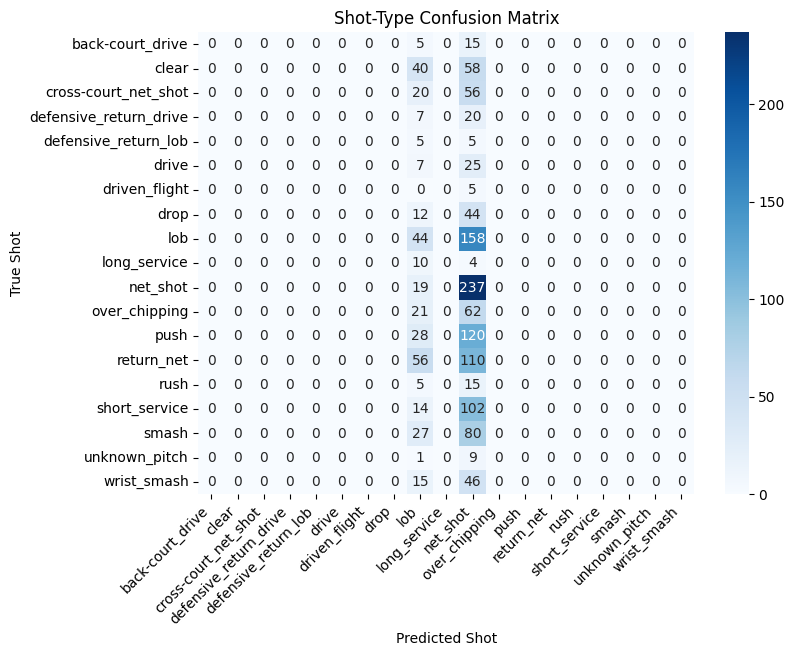

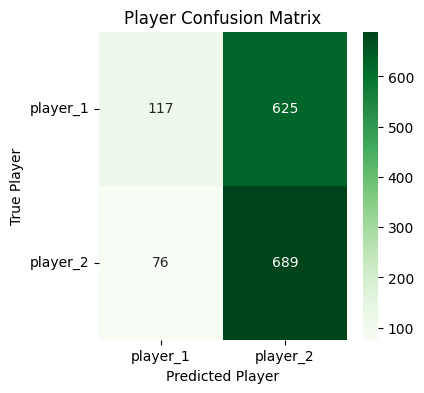

In [23]:
(acts_shot, preds_shot), (acts_pl, preds_pl) = get_actual_predicted_labels(model, test_ds)

# 2. Shot confusion matrix
cm_shot = tf.math.confusion_matrix(acts_shot, preds_shot)
plt.figure(figsize=(8,6))
sns.heatmap(cm_shot, annot=True, fmt="d", 
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues")

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Shot-Type Confusion Matrix")
plt.xlabel("Predicted Shot"); plt.ylabel("True Shot")
plt.show()

# 3. Player confusion matrix
cm_pl = tf.math.confusion_matrix(acts_pl, preds_pl)
plt.figure(figsize=(4,4))
sns.heatmap(cm_pl, annot=True, fmt="d",
    xticklabels=player_names,
    yticklabels=player_names,
    cmap="Greens")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title("Player Confusion Matrix")
plt.xlabel("Predicted Player"); plt.ylabel("True Player")
plt.show()

In [24]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [25]:
precision, recall = calculate_classification_metrics(acts_shot, preds_shot, labels) # Test dataset
precision
recall

/tmp/ipykernel_19/791028922.py:25: RuntimeWarning: invalid value encountered in scalar divide
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision


{'back-court_drive': 0.0,
 'clear': 0.0,
 'cross-court_net_shot': 0.0,
 'defensive_return_drive': 0.0,
 'defensive_return_lob': 0.0,
 'drive': 0.0,
 'driven_flight': 0.0,
 'drop': 0.0,
 'lob': 0.21782178217821782,
 'long_service': 0.0,
 'net_shot': 0.92578125,
 'over_chipping': 0.0,
 'push': 0.0,
 'return_net': 0.0,
 'rush': 0.0,
 'short_service': 0.0,
 'smash': 0.0,
 'unknown_pitch': 0.0,
 'wrist_smash': 0.0}